<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_03_17_GD_2_resnet_34ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

라이브러리 다운

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import os

###모델 만들기

Resnet_34_block



In [4]:
#최종 34 block

def build_resnet_block_34(input_layer, num_cnn, channel, block_num, unit_one=False):

  x = input_layer
  

  for cnn_num in range(num_cnn):

            skip = x

            if not unit_one and cnn_num == 0: #첫번쨰 유닛이 아니고 첫번째 레이어일 때 stride=2 추가
              
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides = 2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_first_conv{cnn_num}'
                )(x)

            else:
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
                )(x)

            
            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_1_bn_{cnn_num}')(x)


            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_activtion_{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_2_conv{cnn_num}'
            )(x)

            if not unit_one: #첫번째 유닛이 아니고 첫번째 레이어일 때 skip레이어 추가
              if cnn_num == 0:

                skip = keras.layers.Conv2D(
                 filters=channel,
                 kernel_size=(1,1),
                 strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name=f'block{block_num}_skip_conv{cnn_num}'
                 )(skip)


            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_2_bn_{cnn_num}')(x)


            if not unit_one: #첫번째 유닛이 아니고 첫번째 레이어일 때 batchnorm 추가
              if cnn_num == 0:
                skip = keras.layers.BatchNormalization(
                  name=f'block{block_num}_skip_bn_{cnn_num}')(skip)


            x = keras.layers.Add()([x,skip])

            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_1_activtion_{cnn_num}')(x)

  return x



에러났던 이유 정리

1. strides 를 안 넣음
2. cnn_num 을 0이  아닌 1로 설정
3. 조건문을 잘못 설정(이게 제일 컸다)
4. add 할 때 shape이 다름
5. name 중복
6. skip레이어 kernel_size = (1,1)

resnet_34

In [5]:
def resnet_34(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10):

  input_layer = keras.layers.Input(shape=input_shape) #input layer 만들기
  output = input_layer

  output = keras.layers.Conv2D(
                 filters=64,
                 kernel_size=(7,7),
                 strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name='block_0_conv'
              )(output)

  output = keras.layers.BatchNormalization(
                name='block_0_bn')(output)

  output = keras.layers.Activation(
                'relu', name = 'block_0_activtion')(output)

  output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2, name = 'MaxPooling')(output)
    

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)): #첫번째 유닛일 때 unit_one = True
    if i == 0:
      output = build_resnet_block_34(output, num_cnn=num_cnn, channel=channel, block_num=i, unit_one = True)
    else:
      output = build_resnet_block_34(output, num_cnn=num_cnn, channel=channel, block_num=i)


  output = keras.layers.AveragePooling2D(pool_size = (1,1),
                                      name = 'last_AveragePooling')(output)

  output = keras.layers.Flatten(name = 'Flatten')(output)
  
  output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

  model = keras.Model(inputs=input_layer, outputs=output)

  return model

In [6]:
resnet_34 = resnet_34()
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block_0_conv (Conv2D)          (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 block_0_bn (BatchNormalization  (None, 16, 16, 64)  256         ['block_0_conv[0][0]']           
 )                                                                                                
                                                                                                  
 block_0_activtion (Activation)  (None, 16, 16, 64)  0           ['block_0_bn[0][0]']         

resnet_50_block

- 34_block에 conv, batch, activ 추가
- stride 없애기
- 커널 사이즈 변경
- 채널 *4

In [7]:
#최종 50 block

def build_resnet_block_50(input_layer, num_cnn, channel, block_num, unit_one=False):

  x = input_layer
  

  for cnn_num in range(num_cnn):

            skip = x

            if not unit_one and cnn_num == 0:
              
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1,1),
                #strides = 2,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_first_conv{cnn_num}'
                )(x)

            else:
              x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1,1),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
                )(x)

            
            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_1_bn_{cnn_num}')(x)


            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_1_activtion_{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_2_conv{cnn_num}'
            )(x)

            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_2_bn_{cnn_num}')(x)


            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_2_activtion_{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel *4,
                kernel_size=(1,1),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_3_conv{cnn_num}'
            )(x)

 
            if cnn_num == 0:

              skip = keras.layers.Conv2D(
                 filters=channel *4,
                 kernel_size=(1,1),
                 #strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name=f'block{block_num}_skip_conv{cnn_num}'
                 )(skip)

                


            x = keras.layers.BatchNormalization(
                name=f'block{block_num}_3_bn_{cnn_num}')(x)


            if cnn_num == 0:
              skip = keras.layers.BatchNormalization(
                    name=f'block{block_num}_skip_bn_{cnn_num}')(skip)
                
            x = keras.layers.Add()([x,skip])

            x = keras.layers.Activation(
                'relu', name = f'block{block_num}_3_activtion_{cnn_num}')(x)

  return x



resnet_50

In [8]:
def resnet_50(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10):

  input_layer = keras.layers.Input(shape=input_shape) #input layer 만들기
  output = input_layer

  output = keras.layers.Conv2D(
                 filters=64,
                 kernel_size=(7,7),
                 strides = 2,
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 name='block_0_conv'
              )(output)

  output = keras.layers.BatchNormalization(
                name='block_0_bn')(output)

  output = keras.layers.Activation(
                'relu', name = 'block_0_activtion')(output)

  output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2, name = 'MaxPooling')(output)
    

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    if i == 0:
      output = build_resnet_block_50(output, num_cnn=num_cnn, channel=channel, block_num=i, unit_one = True)
    else:
      output = build_resnet_block_50(output, num_cnn=num_cnn, channel=channel, block_num=i)


  output = keras.layers.AveragePooling2D(pool_size = (1,1),
                                      name = 'last_AveragePooling')(output)

  output = keras.layers.Flatten(name = 'Flatten')(output)
  
  output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

  model = keras.Model(inputs=input_layer, outputs=output)

  return model

In [9]:
resnet_50 = resnet_50()
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block_0_conv (Conv2D)          (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 block_0_bn (BatchNormalization  (None, 16, 16, 64)  256         ['block_0_conv[0][0]']           
 )                                                                                                
                                                                                                  
 block_0_activtion (Activation)  (None, 16, 16, 64)  0           ['block_0_bn[0][0]']       

###학습

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete5P5O14/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


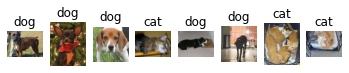

In [10]:
label_name = ['cat', 'dog']
split = ['train[:70%]', 'train[70%:]']

ds_train, ds_test = tfds.load(name='cats_vs_dogs', split = split, as_supervised=True)

i = 0
fig, ax = plt.subplots(1,8)
for image, label in ds_train.take(8):
  ax[i].axis('off')
  ax[i].set_title(label_name[label])
  ax[i].imshow(image)
  i += 1
plt.show()

In [11]:
len(ds_test)

6979

입력 사이즈에 맞게 (32,32)로 resize

In [12]:
HEIGHT = 32
WIDTH = 32

EPOCH = 15

def preprocess(img, label):
  return tf.image.resize(img, [HEIGHT, WIDTH])/255, label

In [13]:
ds_train = ds_train.map(preprocess).batch(16)
ds_test = ds_test.map(preprocess).batch(16)

In [14]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics = ['accuracy']
)

BATCH_SIZE = 16

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch = int(len(ds_train)/BATCH_SIZE),
    validation_steps = int(len(ds_test)/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/15
63/63 [==============================] - 18s 54ms/step - loss: 1.5796 - accuracy: 0.4712 - val_loss: 2.2225 - val_accuracy: 0.4954
Epoch 2/15
63/63 [==============================] - 3s 43ms/step - loss: 1.2790 - accuracy: 0.4950 - val_loss: 2.1902 - val_accuracy: 0.4931
Epoch 3/15
63/63 [==============================] - 3s 44ms/step - loss: 1.1411 - accuracy: 0.5208 - val_loss: 2.1635 - val_accuracy: 0.4931
Epoch 4/15
63/63 [==============================] - 3s 43ms/step - loss: 1.1043 - accuracy: 0.4950 - val_loss: 2.1405 - val_accuracy: 0.4931
Epoch 5/15
63/63 [==============================] - 3s 43ms/step - loss: 1.0699 - accuracy: 0.4821 - val_loss: 2.1107 - val_accuracy: 0.4931
Epoch 6/15
63/63 [==============================] - 3s 48ms/step - loss: 1.0287 - accuracy: 0.5079 - val_loss: 2.0624 - val_accuracy: 0.4884
Epoch 7/15
63/63 [==============================] - 3s 43ms/step - loss: 1.0499 - accuracy: 0.4732 - val_loss: 1.9413 - val_accuracy: 0.4815
Epoch 8/15
6

In [15]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics = ['accuracy']
)

BATCH_SIZE = 16

history_50 = resnet_34.fit(
    ds_train,
    steps_per_epoch = int(len(ds_train)/BATCH_SIZE),
    validation_steps = int(len(ds_test)/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/15
63/63 [==============================] - 3s 43ms/step - loss: 0.8822 - accuracy: 0.4891 - val_loss: 1.2544 - val_accuracy: 0.5255
Epoch 2/15
63/63 [==============================] - 3s 44ms/step - loss: 0.8403 - accuracy: 0.5040 - val_loss: 1.1449 - val_accuracy: 0.5046
Epoch 3/15
63/63 [==============================] - 3s 43ms/step - loss: 0.8502 - accuracy: 0.5119 - val_loss: 1.0925 - val_accuracy: 0.5231
Epoch 4/15
63/63 [==============================] - 3s 43ms/step - loss: 0.8243 - accuracy: 0.5149 - val_loss: 1.0374 - val_accuracy: 0.5116
Epoch 5/15
63/63 [==============================] - 3s 43ms/step - loss: 0.8759 - accuracy: 0.4812 - val_loss: 1.0403 - val_accuracy: 0.4977
Epoch 6/15
63/63 [==============================] - 3s 43ms/step - loss: 0.8338 - accuracy: 0.4881 - val_loss: 1.0008 - val_accuracy: 0.5301
Epoch 7/15
63/63 [==============================] - 3s 46ms/step - loss: 0.8122 - accuracy: 0.5099 - val_loss: 0.9667 - val_accuracy: 0.5417
Epoch 8/15
63

loss 값 나타내기

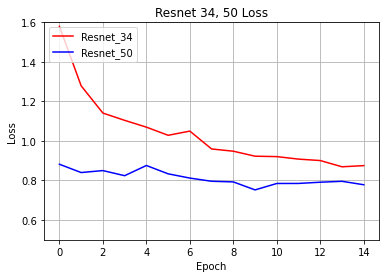

In [16]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Resnet 34, 50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet_34', 'Resnet_50'], loc='upper left')

plt.grid(True)
plt.ylim(0.50, 1.60) #출력하고자하는 accuray 범위 지정
plt.show()

###회고

피그마에 정리

https://www.figma.com/file/Lg5fATrObCkthYPzKMQLHk/Resnet-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0?node-id=11%3A940

LMS 노드와 이미지만 보고 했더니 이해가 되질 않는 부분이 몇개 있었다.

다음에는 시간이 걸리더라도 논문 보면서 해야겠다.